# Convert a MOS file into CSVs

This notebook walks through opening a MOS file and breaking it down into a list of stations. It also has the begginings of parsing the MOS file into a spreadsheet. The end goal is to fully convert the station such that the dataframe matches the output of https://mesonet.agron.iastate.edu/mos/fe.phtml

## Clone
Here we are downloading the folder in which we will work thoughout the summer.

1. open a terminal in the jupyterhub/jetstream 
2.  Clone the mosparse repository into your jupyterhub instance

```bash
https://github.com/ccny-glasslab/mosparse.git
```

## Install
We need to install external libraries and the library we will be modifying, which is called `mosparse`

### Install external library unlzw
We need to use a special library called [unlzw](https://github.com/umeat/unlzw) to unzip our `unlzw` files. Let's install it here: 

In [ ]:
%pip install unlzw

### Install mosparse as editable library
First let's install the library that we're going to be editing. To do this
1. open a terminal
2. cd into mosparse
    ```bash
    cd mosparse
    ```
3. now type ls to list the contents of the folder:
```bash
jovyan@jupyter-<your username>:~/mosparse$ ls
```

The following should show on screen:

```bash
AUTHORS.rst  CONTRIBUTING.rst  docs  LICENSE  MANIFEST.in  mosparse  notes  README.rst  setup.cfg  setup.py  versioneer.py
```

4. If you see a setup.py file, type the following to install an editable version of the source code:
```bash
python -mpip install -ve .
 ```

5. restart the kernel:
(FYI: You will have to take these last two step whenever you close and reopen your program)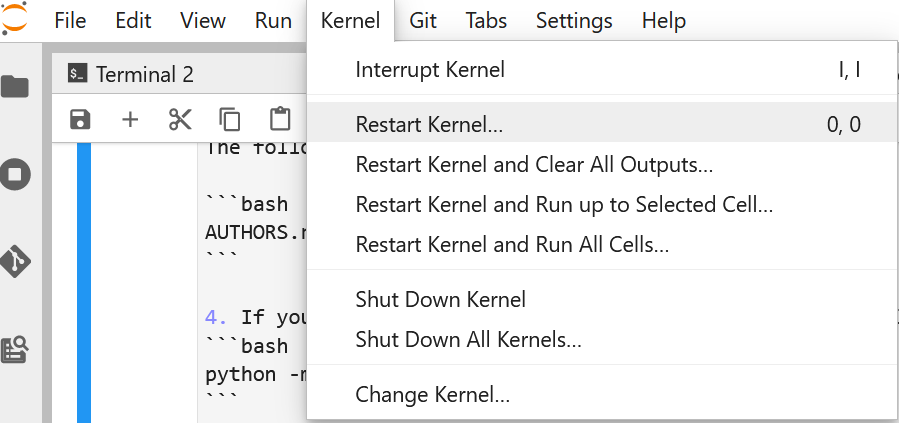

Alternatively:

In [ ]:
%pip install -ve ../mosparse/

The following two lines of code are so that the notebook reloads the libraries every time you make changes.

## Importing Libraries
We need to load the libraries we will be using. We use the `%` [ipython magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html) to automatically reimport our libraries after we save changes to the source code. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [4]:
%conda install pandas

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\story\Anaconda3\envs\mpp

  added / updated specs:
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    mkl-service-2.3.0          |   py38h2bbff1b_0          53 KB
    pandas-1.1.3               |   py38ha925a31_0         9.7 MB
    pytz-2020.4                |     pyhd3eb1b0_0         227 KB
    ------------------------------------------------------------
                                           Total:        10.0 MB

The following NEW packages will be INSTALLED:

  blas               pkgs/main/win-64::blas-1.0-mkl
  intel-openmp       pkgs/main/win-64::intel-openmp-2020.2-254
  mkl                pkgs/main/win-64::mkl-2020.2-256
  mkl-service        pkgs/main/win-64::mkl-service-2.3.0-py38h2bbff1b_0
  mkl_fft            pkgs/main/win-64::mkl_fft-1.2.0-py38h45dec08_0
  mkl_random  

The libraries that will be) used for this example. 
[Pathlib](https://docs.python.org/3/library/pathlib.html)

In [5]:
from pathlib import Path

import mosparse as mp
import mosparse.mavreader as mpr
import mosparse.mavparse as mpp

## Download Data

Lets download one `.Z` file and one `.gz` file from https://sats.nws.noaa.gov/~mos/archives/mav.html

Open a terminal and following commands to download files:
```bash
wget https://sats.nws.noaa.gov/~mos/archives/avnmav/mav202006.t18z.gz
```
make sure to press enter before entering the next command
```bash
wget https://sats.nws.noaa.gov/~mos/archives/avnmav/mav201302.t00z.Z
```
Find the folder that the files are downloaded in by typing the `pwd` command. `pwd` is print working directory.

```bash
jovyan@jupyter-<your username>$ pwd
```

## Open Files
My data is in `/home/jovyan/data`. Here I'm going to assign each location of each file to a variable. I'm using the [Pathlib](https://docs.python.org/3/library/pathlib.html) interface because it simplifies file manipulation. 
We can also tab complete our file path.

In [ ]:
zpath = Path('/home/jovyan/data/mav201302.t00z.Z')
gzpath = Path('/home/jovyan/data/mav202006.t18z.gz')

Let's print out the contents of the`zpath` & `gzpath` variables:

In [ ]:
zpath

In [ ]:
gzpath

Let's check that the file exists, meaning that the computer can find it

In [ ]:
print(zpath.exists(), gzpath.exists())

We're going to try to open our `.gz` file to test that our `MavReader` function works:

In [ ]:
# see if the a *.gz file opens properly
mpr.MavReader(gzpath)

Let's open the file and call it `f` and then print the first 10 lines:

In [ ]:
with mpr.MavReader(gzpath) as f:
    print(list(f)[:10])

### Raw Text

Now we're going to use our function as a context manager and checking if it reads the content properly. The function should return a text [stream](https://docs.python.org/3/library/io.html) object.  

Here we're going to only print the first 10 lines in the file. We're going to use [enumerate](https://docs.python.org/3/library/functions.html#enumerate) and [break](https://docs.python.org/3/tutorial/controlflow.html?highlight=break#break-and-continue-statements-and-else-clauses-on-loops) to keep track of the # of lines and stop at 25.

In [ ]:
# look at the contents of the file 
with mpr.MavReader(gzpath) as f:
    for linenumber, line in enumerate(f):
        #print(linenumber, line)
        pass
    print(linenumber)

Now we're going to try this with a `.Z` file

In [ ]:
# look at the contents of the file 
with mpr.MavReader(zpath) as f:
    for linenumber, line in enumerate(f):
        print(line)
        if linenumber>25:
            break

### Stations 

In the text above, all the stations are in one giant block. Since the [GFS MOS](https://www.weather.gov/mdl/mos_getbull) text product is interpreted on a station by station basis, it'd be easier for us to work with if we could break the text up into a list of stations. 

We do so using the `stations` keyword argument to MavReader. What it does is instead of return a text like above, instead the MavReader converts the text to a generator (which is like a list where the elements only exist on demand) where we can request the station one by one. We use a generator so that we only load the stations as needed. 

Here we print out 1 station to examine it:

In [ ]:
with mpr.MavReader(gzpath, stations=True) as station_generator:
    for i, station in enumerate(station_generator):
        print(f"i={i}, station={station}")
        if i > 1:
            break

## Parse station into spreadsheet (Pandas DataFrame)
We need to convert each station in our list (like the one above) into a spreadsheet. We use the functions in `mav_parse.py` to do our conversion. 

We will walk through the steps here, but all these steps are combined in the `parse_station`

In [ ]:
station

#### Get header information
In the header we store the information common to all variables in the model. 

The first row in the station list is the header information as described in `mav_parse.get_header`

In [ ]:
station[0]

In [ ]:
header = mpp.get_header(station[0])
header

In [ ]:
header['station']

#### Get the finish time
This is the time at which the prediction is supposed to occur. Each mav text product predicts various weather variables at each time and stores predictions for multiple times. Each fntime is a row in our spreadsheet. 

We update the header dictionary. This information is stored in the 2nd and 3rd rows of the station list/text.

In [ ]:
station[1:3]

In [ ]:
header['ftime'] = mpp.get_fntime(station[1], station[2], header)
header

#### Get the measurements

Next we need to pull out the measurements and place them in the right row and column.

In [ ]:
df = mpp.get_rows(header, station)
df

#### Combine all the steps
We packaged all the steps into parse station to make the code most reusable

In [ ]:
df = mpp.parse_station(station)
df

#### write the file

Sometimes it's going to be more convieniant to write the file out into small .csvs that we'll later read into a database or something. This is especially useful in case code breaks.

Here we have the write_station function return the path to the file it wrote:

In [ ]:
mpp.write_station(station)

This generates a .csv file in the mos/modelrun folder. You can open and view this file by clicking on it.

#### log errors
if for whatever reason our parsing doesn't work, we can write the error in a log file.

In [ ]:
station_broken = station.copy()
#lets break the middle row
station_broken[10] = 'a b c d'
station_broken

In [ ]:
mpp.write_station(station_broken)

# Next Steps: Try parsing a whole file into a set of spreadsheets

1. Compose the functions described above to generate a set of spreadsheets that corresponds to each station record in the file.
2. Monitor the logs to see what is broken as that will have to be fixed. 